# Handwritten Recogination using Hybrid Methodology

### Hybrid Methodology is a combination approach of two OCR enigines that are Tesseract OCR and Google Cloud Vision OCR for extracting handwritten text from images

### Loading the required libraries

In [1]:
import os
import cv2
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

import glob

import os
import string

import pytesseract
from Levenshtein import jaro_winkler
from IPython.display import Image as IPythonImage, display

import requests
import time

from base64 import b64encode
from pylab import rcParams

### Loading Identical Texts CSV file and Images

In [2]:
tdf = pd.read_csv("C:\\Users\\Suhal\\Desktop\MS In DA\\Research Project\\Dataset\\archive\\SampleDataset\\RPSheetFinal.csv")
tdf.head()

,FILENAME,IDENTITY
0,DI0000.jpg,BENES
1,DI0001.jpg,LUCIE
2,DI0002.jpg,EMMA
3,DI0003.jpg,ELISE
4,DI0004.jpg,HONNERT


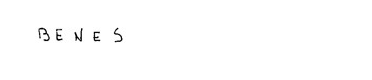

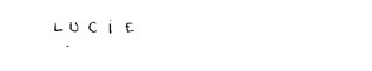

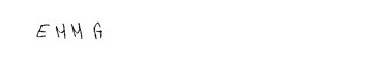

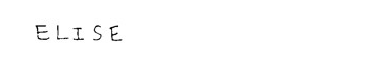

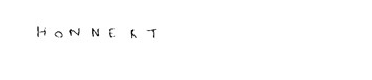

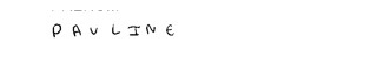

In [3]:
#Reading the Images from the Dataset

for count, file_path in enumerate(glob.glob('C:/Users/Suhal/Desktop/MS In DA/Research Project/Dataset/archive/SampleDataset/DataSet/*.jpg')):
    if(count in range(6)):
        image = cv2.imread(file_path)
        plt.imshow(image)
        plt.axis("off")
        plt.show()

### Resizing the Images

In [4]:
#Resizing the Images

imageNames = glob.glob(r'C:/Users/Suhal/Desktop/MS In DA/Research Project/Dataset/archive/SampleDataset/train/*.jpg')

new_width  = 324
new_height = 44

count=0

for i in imageNames:
    img = Image.open(i)
    img = img.resize((new_width, new_height), Image.ANTIALIAS)
    img.save(r"C:/Users/Suhal/Desktop/MS In DA/Research Project/Dataset/archive/SampleDataset/ResizedImage/"+"DI"+str(count).zfill(4)+".jpg") 
    count+=1
    print("Images Resized " +str(count)+"/"+str(len(imageNames)),end='\r')

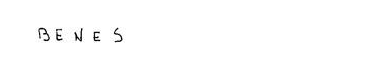

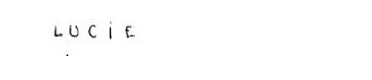

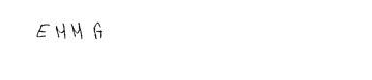

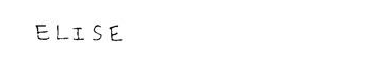

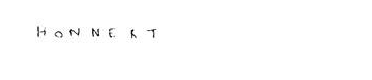

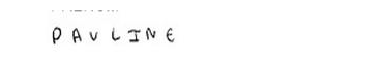

In [5]:
#Viewing the Resized Images 

for count, file_path in enumerate(glob.glob('C:/Users/Suhal/Desktop/MS In DA/Research Project/Dataset/archive/SampleDataset/ResizedImage/*.jpg')):
    if(count in range(6)):
        image = cv2.imread(file_path)
        plt.imshow(image)
        plt.axis("off")
        plt.show()

### Passing Images to Tesseract OCR engine

In [6]:
#Applying the Model

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

path = 'C:/Users/Suhal/Desktop/MS In DA/Research Project/Dataset/archive/SampleDataset/ResizedImage'

output = {}

for row in tdf.itertuples():
    file_path = os.path.join(path, row.FILENAME)
    image = Image.open(file_path)
    text = pytesseract.image_to_string(image)
    output[row.FILENAME] = text
    if ((row.Index + 1) % 500) == 0:
        print(f"Processed {row.Index + 1} rows")

Processed 500 rows
Processed 1000 rows
Processed 1500 rows
Processed 2000 rows
Processed 2500 rows
Processed 3000 rows
Processed 3500 rows
Processed 4000 rows


In [7]:
#Converting the Text converted by Tesseract into DataFrame 

result_df = pd.DataFrame()
for i, (k, v) in enumerate(output.items()):
    if (i + 1) % 500 == 0:
        print(f"Converted output from {i + 1} images")
    
    text = [t for t in v.split('\n') if t not in ['', ' ', '\n', '\x0c']]
    
    temp_df = pd.DataFrame({
        'FILENAME': [k] * len(text), 
        'TEXT': text
    })
    result_df = pd.concat([result_df, temp_df], ignore_index=True)

Converted output from 500 images
Converted output from 1000 images
Converted output from 1500 images
Converted output from 2000 images
Converted output from 2500 images
Converted output from 3000 images
Converted output from 3500 images
Converted output from 4000 images


In [8]:
result_df.head()

,FILENAME,TEXT
0,DI0000.jpg,BENE S
1,DI0001.jpg,LOCcIE
2,DI0002.jpg,EWM G
3,DI0003.jpg,BLE SE
4,DI0004.jpg,HoN NE RT


In [9]:
# Create 1 dataframe with both actual and OCR labels
ocr_vs_actual = tdf.merge(result_df, how='left', on='FILENAME')

# Remove labels and spaces in OCR output
ocr_vs_actual = ocr_vs_actual.loc[ocr_vs_actual['IDENTITY'].notnull(), :]
ocr_vs_actual['TEXT'] = ocr_vs_actual['TEXT'].str.replace('\\s', '', regex=True)

ocr_vs_actual.head()

,FILENAME,IDENTITY,TEXT
0,DI0000.jpg,BENES,BENES
1,DI0001.jpg,LUCIE,LOCcIE
2,DI0002.jpg,EMMA,EWMG
3,DI0003.jpg,ELISE,BLESE
4,DI0004.jpg,HONNERT,HoNNERT


In [10]:
#Saving the Output of Tessercat 

ocr_vs_actual.to_csv('C:\\Users\\Suhal\\Desktop\\MS In DA\\Research Project\\Dataset\\archive\\SampleDataset\\TesseractOutput.csv', index=False)

### Passing Images to Google Cloud Vision OCR

In [11]:
#Loading the authentication file

import json

with open('vision_api.json') as f:
    data = json.load(f)

In [12]:
#Encoding the images and selcting the features

def makeImageData(imgpath):
    img_req = None
    with open(imgpath, 'rb') as f:
        ctxt = b64encode(f.read()).decode()
        img_req = {
            'image': {
                'content': ctxt
            },
            'features': [{
                'type': 'DOCUMENT_TEXT_DETECTION',
                'maxResults': 1
            }]
        }
    return json.dumps({"requests": img_req}).encode()

In [13]:
#Response function of Google Vision OCR

def requestOCR(url, api_key, imgpath):
  imgdata = makeImageData(imgpath)
  response = requests.post(ENDPOINT_URL, 
                           data = imgdata, 
                           params = {'key': api_key}, 
                           headers = {'Content-Type': 'application/json'})
  return response

In [14]:
#Setting the Endpint and API Key

ENDPOINT_URL = 'https://vision.googleapis.com/v1/images:annotate'
api_key = data["api_key"]

In [15]:
#Passing the images 

text_output =[]
for file in glob.glob("C:\\Users\\Suhal\\Desktop\\MS In DA\\Research Project\\Dataset\\archive\\SampleDataset\\ResizedImage\\*.jpg"):
    
    result = requestOCR(ENDPOINT_URL, api_key, file)
    if result.status_code != 200 or result.json().get('error'):
        print ("Error")
    else:
        if len(result.json()['responses'][0]) == 0:
            result = result.json()['responses'][0]
            text_output.append(result)
        else:
            result = result.json()['responses'][0]['textAnnotations']
            text_output.append(result)

In [16]:
#Viewing the extracted texts

for index in range(len(text_output)):
    if len(text_output[index])!= 0:
        print(text_output[index][0]['description'])
    else:
        print(text_output[index])

BENES

LUCIE

EMMG

ELISE

HONNEKT

P AV LINE

ROMAIN

CYRIELLE

00717

MIT HIEUX

THOMAS

ANATS

I AFFEUX

ROMANE

BRUGERIE

LORENTIN

ELISA

MAUPAS

MESSA

{}
& Rwai

AMBROISE

EL BAKKALi

BENZINA

LA QUE RRIERE

YAEL

VITRE

GuiLL OT GOGUET

MATHÉO

SHA

VICTORIA

BARBIER

DUPRAT

LEBARH

REMI

ARGITXU

SINEM

RODRIGUES

AUBANE

ELISA

A CHOURT

Antoine

JULIE

BallGEAU

TROUVAI

CORALIE

VANDENAREELE

ASHLEY

AMBROS

GAROT

HILIANI - THIDA

THEO

VINCENT

5 : ло1

VERSTRAËT E

iuc

GUILLO

COLLIN

FERON

DA UMESNIL

BOUTE 1

BERNARD

BE NLAH SEN

coss A

BELOEIL

MARTINS

BRACONNIER

ВАРТ i5 тв

SAT DANI

VINÇOTTE

BENSAIS RUEDA

Luc

GARCIA

ALEXANDRE

HALTET

PEREZ

ANDRE

GUST

{}
CADWAL

WATTEZ

CORDON

{}
COCHERiL

FONTAINE

SI ME ON

GARCIA

LEGRAND

CORENTIN

ENATH

EMMA

{}
TRIST AN

RODRIGUEZ

PIBOURRET

HASSI

CROENNE

0077

yo coubi

{}
Max, ME

GIBAJA

Во BC RT

Eloist
AC

AMAL

DYLAN

обо

FLORA

ELOIN

DUAULT

BROSSARD

GWENOLA

TANGUY

CAROL ANE

EDGAR

TUROux

CLEME


ALAN

JENNIFER

CLEMENT

CHAH LAL

KEVIN

NATheo

T TOUAN

PARA viD AL

NATHAN

AMBRE

CHAUVINE AU

COQUARD - SibOUN;

ALLIK

CLARA

BURGER

CESARIE

ANNE HELENE

CLARA

VI ANNEY

GAATEAU

βου και ΣΜΑ

EMILIE

Tara quos

JULES

SAILLON

ANNA

GODARD

DUMOULIN

KASSANDR#

KEBBRAT

QUENTIN

GRANGER

EDGAR

ILYAS

.
AGOSSOU

YANIS

ВАосот

CORENTIN

ZIANI

BRACCO

MAHEUT

JEANNE

ARTHUR

MARIO

CONSTANCE

VO ESSLER

KiLYAN

MAXENS

AXEL

NOM :
PREAUX

ERENOM : KENTON

NICOLAE

SALMAN

{}
{}
MO UNEYRAL

PASCAL

NOM
MORAND

KYLIANN

N G ) { & N

LHEUREUX. PETIT

Maulis

ESTEBAN

LE COMTE

MATTHIEU

USIO7

COUD URIER

AXEL

OCÉANE

DANGER

SADE

LAURINE

HAUD

BAYON

67ר6

ЕНңе

NONY

ANDRE

MAEVA

нтна

Mindis

NAJIB В

TRISTAN

MUSA

PiS SON

BAPHAËLLE

PENNEC

CHELSEA

{}
JUSTINE

LUBIN

JEHANNO

PEREIRA

AUDREY

GOBET

LEti

PARIS

MELILLI-LOPEZ

TUFEiGo

KINGUE

FERRY

ANAIS

wiss AL

PAULINE

SECK

PINEAU

LOLA

ANTONE

CHARLINE

DETTE

KEVIN

DE ANTONI

SACHA

IRGUI

KUZNETSOVA

LE N

ANA ELLE

DE MATOS

RUYTERS

ELISA

BRENEAU

ARNAUD

OCEANE

SARAH

BARRÉ

GARRIC

LOLA

KHUON

ALVES -- LINAH

JULIETTE

GONOT

LASCAR

KYLIAN

CECILE

GOEMAERE

AMELIA

LOLA

ADAM

DATTEE

BERTIE

{}
MEUR IN

MESSAL

HEHEUT

BLANCHONG
-

ROMARIC

SYLVAIN

JONATHAN

RUBEN

QUENTIN

CHARLES

My L14!

Nicolas

NOAM

LE RIGAB

AMINATA

BiELER

SO ER ENSEN

EDGARD

BOUCHARD

Псна пе 2

GALLET

A ORIEN

AMBRE

DAULT DE
viLLi ER

BLANC

ANNE-LISE

тно мнЅ

пATHYS

ANTOINE

CUENOT

BRISSON

3N 2 хҒА

RCUAULT

MATHiLDE

ANDREANA

RAHOINT

AMANDINE

REDSDAL

MATHILDE

BOOTE

MONNIER

ΚΑΙΟ
*

IRIS

COSTARD

HATHYS

JAEGER

AMELIE

KLIEBER

PETO

E MRIS

२. STOPHE

ANTONIN

TISSERAND

ко (АЯ КНЯСА

ר סר 4

KORENTIN

ZINCK

LISE A

ALEXANDRE

VINCENT

ADEL

LAFFAILLE

FLORE

LUSS ANDRE

MAISON

SOILIHI

ROLE AND

Le coa

PARENT

SOFIA

DELMoTTE

ב 2:30

BUREAU

- 2017

ILHAN

ZOE

KEMIL

MAEVA

RAFAEL

YANNIS

PAUL

ER DE

MANEL

LOUNGAR

SAUNIER

0707

КАХ І НЕ

MATTHIAS

PIERRE

KENAN

LED 0

B

LILIAN

НЕКревесн

A6ATнE

Во отсніс НЕ

GAYE

BOL TON

DES HAYES

BOU A NANI

BOISSE WINORANDJEAN

lenny

SALVAT

KHANOUCH

ROMANE

ΕΜΜΑ

вче5

THOMAS

SERVANE

ТОМ

ESTEVES

INNA-LYNN

SILVA

BOV TOILLE

STEPHAN

FELIX

6 [LL16 R

CAMUS

KOCHALSKI

דוס 8
9

BOURGEOIS

VALENTIN

TINA

LACOUR

BENK EMO UN

EHRSAM - THOMAS

MAXENCE

BARilloi

ARTHUR

MARION

LO QUA is

LEIS

BEATRIX

BERNAMA

TOM

LEFRANC

FASSI AUX

{}
PERRIDE

HENRY ON

DECOTTE

BALLARD

CHAMPETIER

CO SNEAU

EMMANUELLE

MATHYS

ALEN DROIT

OMBELINE

ALEX ľS

ZA MAGLIONE

TOURNIE

ROMain

LEO

8 רץ א 2

LINCY

QUENTIN

VARACHE

LAFAILLE

TiE BI

ANTONIN

NA IDJi

TOMASSORE

ESTHER

LENATS

CHLOE

ASSIA

ZOE

G ή ει

GALOT

BORTOS

Том

E DOUARD

A B DELLAOUI

SANUEL

ENGUERRAND

TY FENN

AKG UL

NOM :

WARIN

MI A ILHE

MARIE-EVE

VICTOR

PRENOM:

NVAONO

VANNI

PRENOM: EMERIC

H
NOM :
FERRE

ANNABELLE

ΤΟ ΚΑΝ Νου

WASS, on a

PRENOM: ALEXANDRE

Joc 9

| 102

VILLESSE CHE

BRETON

NOM :
BARC

NOM :
Boislave
21

ELEONO

In [17]:
#Converting the extracted text into data frame

import imutils

list_excel = []
for index in range(len(text_output)):
    if len(text_output[index])!= 0:
        list_excel.append(text_output[index][0]['description'])
    else:
        list_excel.append(text_output[index])

In [18]:
gdf = pd.DataFrame(list_excel,columns=['Text Output'])

In [19]:
gdf.head()

,Text Output
0,BENES\n
1,LUCIE\n
2,EMMG\n
3,ELISE\n
4,HONNEKT\n


In [20]:
#Mergin it with the Actual texts CSV

gvdf = pd.merge(tdf,gdf, left_index=True, right_index=True, how='left')

gvdf.head()

,FILENAME,IDENTITY,Text Output
0,DI0000.jpg,BENES,BENES\n
1,DI0001.jpg,LUCIE,LUCIE\n
2,DI0002.jpg,EMMA,EMMG\n
3,DI0003.jpg,ELISE,ELISE\n
4,DI0004.jpg,HONNERT,HONNEKT\n


In [21]:
gvdf = gvdf.rename(columns={'Text Output': 'GVText'})

In [23]:
#Saving the Google Vision Output

gvdf.to_csv('C:\\Users\\Suhal\\Desktop\\MS In DA\\Research Project\\Dataset\\archive\\SampleDataset\\GCPOutput.csv', index=False)

## Hybrid Methodology Function

In [24]:
#Loading the GCV extracted texts CSV

GVdf = pd.read_csv("C:\\Users\\Suhal\\Desktop\MS In DA\\Research Project\\Dataset\\archive\\SampleDataset\\GCPOutput.csv")
GVdf.head(4000)

,FILENAME,IDENTITY,GVText
0,DI0000.jpg,BENES,BENES\r\n
1,DI0001.jpg,LUCIE,LUCIE\r\n
2,DI0002.jpg,EMMA,EMMG\r\n
3,DI0003.jpg,ELISE,ELISE\r\n
4,DI0004.jpg,HONNERT,HONNEKT\r\n
5,DI0005.jpg,PAULINE,P AV LINE\r\n
6,DI0006.jpg,ROMAIN,ROMAIN\r\n
7,DI0007.jpg,CYRIELLE,CYRIELLE\r\n
8,DI0008.jpg,LILOU,00717\r\n
9,DI0009.jpg,MITHIEUX,MIT HIEUX\r\n


In [25]:
#Removing the labels and spaces from GCV 

GVdf = GVdf.replace(r'\n',' ', regex=True)
GVdf = GVdf.replace(r'\r',' ', regex=True)
GVdf = GVdf.replace(r'  ','', regex=True)

GVdf.head()

,FILENAME,IDENTITY,GVText
0,DI0000.jpg,BENES,BENES
1,DI0001.jpg,LUCIE,LUCIE
2,DI0002.jpg,EMMA,EMMG
3,DI0003.jpg,ELISE,ELISE
4,DI0004.jpg,HONNERT,HONNEKT


In [26]:
#Jaro-winkler similarity score for Google Vision 

vectorized_jaro_winkler = np.vectorize(jaro_winkler)

GVdf['SIMILARITY_SCORE_GoogelVision'] = vectorized_jaro_winkler(GVdf['IDENTITY'].str.upper(),np.where(GVdf['GVText'].isnull(),'',GVdf['GVText'].str.upper()))
GVdf.head(10)

,FILENAME,IDENTITY,GVText,SIMILARITY_SCORE_GoogelVision
0,DI0000.jpg,BENES,BENES,1.000000
1,DI0001.jpg,LUCIE,LUCIE,1.000000
2,DI0002.jpg,EMMA,EMMG,0.883333
3,DI0003.jpg,ELISE,ELISE,1.000000
4,DI0004.jpg,HONNERT,HONNEKT,0.952381
5,DI0005.jpg,PAULINE,P AV LINE,0.857143
6,DI0006.jpg,ROMAIN,ROMAIN,1.000000
7,DI0007.jpg,CYRIELLE,CYRIELLE,1.000000
8,DI0008.jpg,LILOU,00717,0.000000
9,DI0009.jpg,MITHIEUX,MIT HIEUX,0.974074


In [27]:
#Loading the Tessercat OCR extracted texts CSV

TEdf = pd.read_csv("C:\\Users\\Suhal\\Desktop\\MS In DA\\Research Project\\Dataset\\archive\\SampleDataset\\TesseractOutput.csv")
TEdf.head(10)

,FILENAME,IDENTITY,TEXT
0,DI0000.jpg,BENES,BENES
1,DI0001.jpg,LUCIE,LOCcIE
2,DI0002.jpg,EMMA,EWMG
3,DI0003.jpg,ELISE,BLESE
4,DI0004.jpg,HONNERT,HoNNERT
5,DI0005.jpg,PAULINE,PAvirve
6,DI0006.jpg,ROMAIN,Rom4iwv
7,DI0007.jpg,CYRIELLE,CyRiELLE
8,DI0008.jpg,LILOU,LTLOU
9,DI0009.jpg,MITHIEUX,A\VRIEUR


In [28]:
#Jaro-winkler similarity score for Tesseract 

vectorized_jaro_winkler = np.vectorize(jaro_winkler)

TEdf['SIMILARITY_SCORE_Tesseract'] = vectorized_jaro_winkler(TEdf['IDENTITY'].str.upper(),np.where(TEdf['TEXT'].isnull(),'',TEdf['TEXT'].str.upper()))
TEdf.head(10)

,FILENAME,IDENTITY,TEXT,SIMILARITY_SCORE_Tesseract
0,DI0000.jpg,BENES,BENES,1.000000
1,DI0001.jpg,LUCIE,LOCcIE,0.840000
2,DI0002.jpg,EMMA,EWMG,0.700000
3,DI0003.jpg,ELISE,BLESE,0.783333
4,DI0004.jpg,HONNERT,HoNNERT,1.000000
5,DI0005.jpg,PAULINE,PAvirve,0.771429
6,DI0006.jpg,ROMAIN,Rom4iwv,0.822222
7,DI0007.jpg,CYRIELLE,CyRiELLE,1.000000
8,DI0008.jpg,LILOU,LTLOU,0.880000
9,DI0009.jpg,MITHIEUX,A\VRIEUR,0.583333


In [29]:
#Merging the Tessercat and GCV data frames with similarity score

Hdf = pd.merge(TEdf,GVdf, on = ['FILENAME', 'IDENTITY'], how = "left")
Hdf.head(10)

,FILENAME,IDENTITY,TEXT,SIMILARITY_SCORE_Tesseract,GVText,SIMILARITY_SCORE_GoogelVision
0,DI0000.jpg,BENES,BENES,1.000000,BENES,1.000000
1,DI0001.jpg,LUCIE,LOCcIE,0.840000,LUCIE,1.000000
2,DI0002.jpg,EMMA,EWMG,0.700000,EMMG,0.883333
3,DI0003.jpg,ELISE,BLESE,0.783333,ELISE,1.000000
4,DI0004.jpg,HONNERT,HoNNERT,1.000000,HONNEKT,0.952381
5,DI0005.jpg,PAULINE,PAvirve,0.771429,P AV LINE,0.857143
6,DI0006.jpg,ROMAIN,Rom4iwv,0.822222,ROMAIN,1.000000
7,DI0007.jpg,CYRIELLE,CyRiELLE,1.000000,CYRIELLE,1.000000
8,DI0008.jpg,LILOU,LTLOU,0.880000,00717,0.000000
9,DI0009.jpg,MITHIEUX,A\VRIEUR,0.583333,MIT HIEUX,0.974074


In [30]:
#creating new columns HybridText and ModelContribution

Hdf["HybridText"] = [np.nan] * len(Hdf)
Hdf['ModelContribution'] = [np.nan] * len(Hdf)

In [31]:
Hdf.head()

,FILENAME,IDENTITY,TEXT,SIMILARITY_SCORE_Tesseract,GVText,SIMILARITY_SCORE_GoogelVision,HybridText,ModelContribution
0,DI0000.jpg,BENES,BENES,1.000000,BENES,1.000000,NaN,NaN
1,DI0001.jpg,LUCIE,LOCcIE,0.840000,LUCIE,1.000000,NaN,NaN
2,DI0002.jpg,EMMA,EWMG,0.700000,EMMG,0.883333,NaN,NaN
3,DI0003.jpg,ELISE,BLESE,0.783333,ELISE,1.000000,NaN,NaN
4,DI0004.jpg,HONNERT,HoNNERT,1.000000,HONNEKT,0.952381,NaN,NaN


In [32]:
#Hybrid Methodology Function 
#Calculates the highest similarity score and on the basis of that fills the columns Hybrid Text and ModelContribution

for count, row in enumerate(Hdf["HybridText"]):
    if(Hdf.SIMILARITY_SCORE_Tesseract[count] > Hdf.SIMILARITY_SCORE_GoogelVision[count]):
            Hdf.HybridText[count] = Hdf.TEXT[count]
            Hdf.ModelContribution[count] = "Tesseract"
    elif(Hdf.SIMILARITY_SCORE_Tesseract[count] == Hdf.SIMILARITY_SCORE_GoogelVision[count]):
        Hdf.HybridText[count] = Hdf.GVText[count]
        Hdf.ModelContribution[count] = "Both"
    else:
        Hdf.HybridText[count] = Hdf.GVText[count]
        Hdf.ModelContribution[count] = "GoogelVision"

C:\Users\Suhal\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Suhal\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Suhal\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Suhal\Anacon

In [33]:
Hdf.head(10)

,FILENAME,IDENTITY,TEXT,SIMILARITY_SCORE_Tesseract,GVText,SIMILARITY_SCORE_GoogelVision,HybridText,ModelContribution
0,DI0000.jpg,BENES,BENES,1.000000,BENES,1.000000,BENES,Both
1,DI0001.jpg,LUCIE,LOCcIE,0.840000,LUCIE,1.000000,LUCIE,GoogelVision
2,DI0002.jpg,EMMA,EWMG,0.700000,EMMG,0.883333,EMMG,GoogelVision
3,DI0003.jpg,ELISE,BLESE,0.783333,ELISE,1.000000,ELISE,GoogelVision
4,DI0004.jpg,HONNERT,HoNNERT,1.000000,HONNEKT,0.952381,HoNNERT,Tesseract
5,DI0005.jpg,PAULINE,PAvirve,0.771429,P AV LINE,0.857143,P AV LINE,GoogelVision
6,DI0006.jpg,ROMAIN,Rom4iwv,0.822222,ROMAIN,1.000000,ROMAIN,GoogelVision
7,DI0007.jpg,CYRIELLE,CyRiELLE,1.000000,CYRIELLE,1.000000,CYRIELLE,Both
8,DI0008.jpg,LILOU,LTLOU,0.880000,00717,0.000000,LTLOU,Tesseract
9,DI0009.jpg,MITHIEUX,A\VRIEUR,0.583333,MIT HIEUX,0.974074,MIT HIEUX,GoogelVision


In [34]:
#Dropping the unwanted Columns

Hdf = Hdf.drop(['TEXT','SIMILARITY_SCORE_Tesseract','GVText','SIMILARITY_SCORE_GoogelVision'],axis='columns')
Hdf.head(10)

,FILENAME,IDENTITY,HybridText,ModelContribution
0,DI0000.jpg,BENES,BENES,Both
1,DI0001.jpg,LUCIE,LUCIE,GoogelVision
2,DI0002.jpg,EMMA,EMMG,GoogelVision
3,DI0003.jpg,ELISE,ELISE,GoogelVision
4,DI0004.jpg,HONNERT,HoNNERT,Tesseract
5,DI0005.jpg,PAULINE,P AV LINE,GoogelVision
6,DI0006.jpg,ROMAIN,ROMAIN,GoogelVision
7,DI0007.jpg,CYRIELLE,CYRIELLE,Both
8,DI0008.jpg,LILOU,LTLOU,Tesseract
9,DI0009.jpg,MITHIEUX,MIT HIEUX,GoogelVision


In [35]:
#Jaro-winkler similarity score for Hybrid Methodology's Hybrid Texts 

vectorized_jaro_winkler = np.vectorize(jaro_winkler)

Hdf['SIMILARITY_SCORE_HybridModel'] = vectorized_jaro_winkler(Hdf['IDENTITY'].str.upper(),np.where(Hdf['HybridText'].isnull(),'',Hdf['HybridText'].str.upper()))
Hdf.head(10)

,FILENAME,IDENTITY,HybridText,ModelContribution,SIMILARITY_SCORE_HybridModel
0,DI0000.jpg,BENES,BENES,Both,1.000000
1,DI0001.jpg,LUCIE,LUCIE,GoogelVision,1.000000
2,DI0002.jpg,EMMA,EMMG,GoogelVision,0.883333
3,DI0003.jpg,ELISE,ELISE,GoogelVision,1.000000
4,DI0004.jpg,HONNERT,HoNNERT,Tesseract,1.000000
5,DI0005.jpg,PAULINE,P AV LINE,GoogelVision,0.857143
6,DI0006.jpg,ROMAIN,ROMAIN,GoogelVision,1.000000
7,DI0007.jpg,CYRIELLE,CYRIELLE,Both,1.000000
8,DI0008.jpg,LILOU,LTLOU,Tesseract,0.880000
9,DI0009.jpg,MITHIEUX,MIT HIEUX,GoogelVision,0.974074


In [36]:
#Printing the contribution of each model

ddf = Hdf['ModelContribution'].value_counts(normalize=True)
print("Contribution of Engines to the Hybrid Methodology")
ddf * 100

Contribution of Engines to the Hybrid Methodology


GoogelVision    46.425
Both            34.350
Tesseract       19.225
Name: ModelContribution, dtype: float64

In [37]:
#Checking the mean and std of each engine and Hybrid Methodology

from numpy import mean
from numpy import std

print('The mean=%.3f and stdv=%.3f of Hybrid Methodology' % (mean(Hdf.SIMILARITY_SCORE_HybridModel), std(Hdf.SIMILARITY_SCORE_HybridModel)))

print('The mean=%.3f and stdv=%.3f of Google Vision OCR' % (mean(GVdf['SIMILARITY_SCORE_GoogelVision']), std(GVdf['SIMILARITY_SCORE_GoogelVision'])))

print('The mean=%.3f stdv=%.3f of Tesseract OCR' % (mean(TEdf['SIMILARITY_SCORE_Tesseract']), std(TEdf['SIMILARITY_SCORE_Tesseract'])))

The mean=0.952 and stdv=0.136 of Hybrid Methodology
The mean=0.879 and stdv=0.279 of Google Vision OCR
The mean=0.864 stdv=0.219 of Tesseract OCR


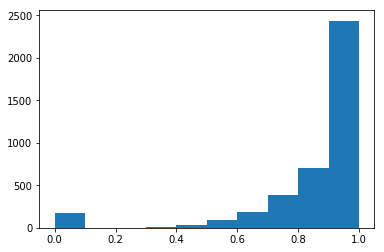

In [38]:
#Plotting Histogram for SIMILARITY SCORE of Tesseract OCR Engine

from matplotlib import pyplot

pyplot.hist(TEdf['SIMILARITY_SCORE_Tesseract'])
pyplot.show()

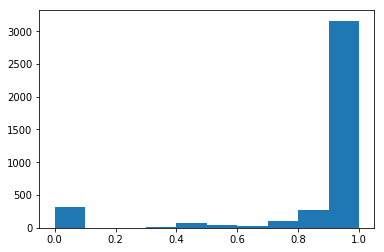

In [39]:
#Plotting Histogram for SIMILARITY SCORE of Google Vision OCR 

from matplotlib import pyplot

pyplot.hist(GVdf['SIMILARITY_SCORE_GoogelVision'])
pyplot.show()

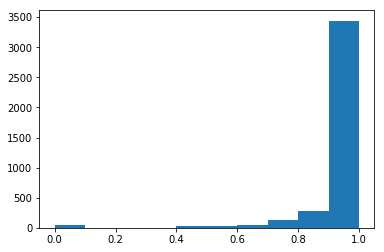

In [40]:
#Plotting Histogram for SIMILARITY SCORE of Hybrid Methodology 

from matplotlib import pyplot

pyplot.hist(Hdf.SIMILARITY_SCORE_HybridModel)
pyplot.show()

In [41]:
#Wilcoxon Rank Sum test for each engine 


from scipy import stats
from scipy.stats import ranksums


gt = stats.wilcoxon(GVdf['SIMILARITY_SCORE_GoogelVision'], TEdf['SIMILARITY_SCORE_Tesseract'])
print("Wilcoxon Score for Google Vision OCR and Tesseract OCR is", gt)
print('\n')

hg = stats.wilcoxon(Hdf['SIMILARITY_SCORE_HybridModel'], GVdf['SIMILARITY_SCORE_GoogelVision'])
print("Wilcoxon Score for Google Vision OCR and Hybrid Methodology is", hg)
print('\n')

ht = stats.wilcoxon(Hdf['SIMILARITY_SCORE_HybridModel'], TEdf['SIMILARITY_SCORE_Tesseract'])
print("Wilcoxon Score for Tesseract OCR and Hybrid Methodology is", ht)
print('\n')

rgt = ranksums(GVdf['SIMILARITY_SCORE_GoogelVision'], TEdf['SIMILARITY_SCORE_Tesseract'])
print("Rank Sum Score for Google Vision OCR and Tesseract OCR is", rgt)
print('\n')

rhg = ranksums(Hdf['SIMILARITY_SCORE_HybridModel'], GVdf['SIMILARITY_SCORE_GoogelVision'])
print("Rank Sum Score for Google Vision OCR and Hybrid Methodology is", rhg)
print('\n')

rht = ranksums(Hdf['SIMILARITY_SCORE_HybridModel'], TEdf['SIMILARITY_SCORE_Tesseract'])
print("Rank Sum Score for Tesseract OCR and Hybrid Methodology is", rht)

Wilcoxon Score for Google Vision OCR and Tesseract OCR is WilcoxonResult(statistic=1138701.0, pvalue=2.219058976590537e-51)


Wilcoxon Score for Google Vision OCR and Hybrid Methodology is WilcoxonResult(statistic=447.0, pvalue=5.836058203647799e-127)


Wilcoxon Score for Tesseract OCR and Hybrid Methodology is WilcoxonResult(statistic=1747.0, pvalue=1.0696875555850761e-303)


Rank Sum Score for Google Vision OCR and Tesseract OCR is RanksumsResult(statistic=19.033284248845174, pvalue=9.040510770421894e-81)


Rank Sum Score for Google Vision OCR and Hybrid Methodology is RanksumsResult(statistic=7.81795128659381, pvalue=5.368995867837815e-15)


Rank Sum Score for Tesseract OCR and Hybrid Methodology is RanksumsResult(statistic=28.225235742052064, pvalue=2.866712183090727e-175)
